# Building an AWS Solution Architect Agent with Generative AI

This notebook walks through  building an AI-powered Solution Architect Agent dubbed "Agent AWS" using HuggingFace Transformers and AWS Sagemaker.

The three tools for Agent AWS are:

1. **AWS Well-Architected Framework Query Tool**: This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.
2. **Code Generation Tool:** This tool will generate code from AWS CloudFormation scripts to Java code.
3. **Diagram Creation Tool:** This tool will create AWS diagrams.

## Agent AWS

**Agent AWS** is an automated, AI-powered agent that uses HuggingFace Transformers paired with numerous different foundation models. 

An “agent” here is a large language model (LLM) equipped with a prompt and access to a specific set of tools. Tools are self-contained functions that perform a singular task that the agent can use when given an instruction.

Agent AWS contains a set of tools that allows it to query AWS documentation, generating code, and creating architectural diagrams.

In [1]:
# Import libraries
import time
import transformers
import langchain
import pickle
import requests
from PIL import Image
from transformers import Tool
from transformers.tools import HfAgent
import os
import openai
from langchain.chat_models import ChatOpenAI
from langchain.prompts.prompt import PromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

from typing import Dict
from langchain import PromptTemplate, SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.chains.question_answering import load_qa_chain
import json
import boto3

import yaml
import logging
import sys
import shutil
import subprocess
import zipfile

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Agent Prompt

The language model powering the agent is conditioned on a long prompt that the user provides. Using that prompt the model is able to generate words to complete the user’s request. 

The prompt is structured broadly into two parts.

1. Role: How the agent should behave, explanation of the concept of tools.
2. Examples of tasks and their solution


In [2]:
sa_prompt = """
You are an expert AWS Certified Solutions Architect. Your role is to help customers understand best practices on building on AWS. You will generate Python commands using available tools to help will customers solve their problem effectively.
To assist you, you have access to three tools. Each tool has a description that explains its functionality, the inputs it takes, and the outputs it provides.
First, you should explain which tool you'll use to perform the task and why. Then, you'll generate Python code. Python instructions should be simple assignment operations. You can print intermediate results if it's beneficial.

Tools:
<<all_tools>>

Task: "Help customers understand best practices on building on AWS by using relevant context from the AWS Well-Architected Framework."

I will use the AWS Well-Architected Framework Query Tool because it provides direct access to AWS Well-Architected Framework to extract information.

Answer:
```py
response = well_architected_tool(query="How can I design secure VPCs?")
print(f"{response}.")
```

Task: "Generate a CloudFormation script for a web application with an EC2 instance, an S3 bucket, and a RDS database."

I will use the Code Generation Tool because it can create AWS CloudFormation scripts based on the provided requirements.

Answer:
```py

cloudformation_script = code_generation_tool(prompt="Web application with an EC2 instance, an S3 bucket, and a RDS database.")
print(f"{cloudformation_script}")
```

Task: "Create a diagram for the following architecture: three EC2 instances connected to an S3 bucket and a RDS database."

I will use the Diagram Creation Tool because it can create insightful diagrams to represent the given AWS architecture.

Answer:

```py
architecture_diagram = diagram_creation_tool(query="Three EC2 instances connected to an S3 bucket and a RDS database.")
```


Task: "<<prompt>>"

I will use the following
"""

## Tools

Now that we have defined our agent prompt, the next step is to create the tools for the agent to use. Tools are very simple: they’re a single function, with a name, and a description. The descriptions are used to prompt the agent to complete tasks. 

### AWS Well-Architected Framework Query Tool
This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.

This notebook is using the AI21 Jurassic-2 Grande instruct foundation model provided by Amazon SageMaker JumpStart.
You will need to deploy your own model or input a different model. Use this notebook as a template of what can be built

Resources:
1. https://aws.amazon.com/sagemaker/jumpstart/
2. https://aws.amazon.com/blogs/machine-learning/ai21-jurassic-1-foundation-model-is-now-available-on-amazon-sagemaker/

In [3]:
class AWSWellArchTool(Tool):
    name = "well_architected_tool"
    description = "Use this tool for any AWS related question to help customers understand best practices on building on AWS. It will use the relevant context from the AWS Well-Architected Framework to answer the customer's query. The input is the customer's question. The tool returns an answer for the customer using the relevant context."
    inputs = ["text"]
    outputs = ["text"]

    def qa_chain(self):
        prompt_template = """Use the following pieces of context to answer the question at the end.

        {context}

        Question: {question}
        Answer:"""
        PROMPT = PromptTemplate(
            template=prompt_template, input_variables=["context", "question"]
        )

        class ContentHandler(LLMContentHandler):
            content_type = "application/json"
            accepts = "application/json"

            def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
                # clean prompt
                prompt = prompt.replace("\\n,", "").replace("\n", "").strip()

                payload = {
                    "prompt": prompt,
                    "maxTokens": 2048,
                    "temperature": 0.7,
                    "numResults": 1,
                }

                payload = json.dumps(payload).encode("utf-8")
                return payload

            def transform_output(self, output: bytes) -> str:
                response_json = json.loads(output.read().decode("utf-8"))
                return response_json["completions"][0]["data"]["text"]

        content_handler = ContentHandler()
        # Setup chain
        chain = load_qa_chain(
            llm=SagemakerEndpoint(
                endpoint_name="j2-grande-instruct",
                region_name="us-east-1",
                credentials_profile_name="default", 
                content_handler=content_handler,
            ),
            prompt=PROMPT,
        )

        return chain

    def __call__(self, query):
        chain = self.qa_chain()
        # Find docs
        embeddings = HuggingFaceEmbeddings()
        vectorstore = FAISS.load_local("local_index", embeddings)
        docs = vectorstore.similarity_search(query)

        doc_sources_string = ""
        for doc in docs:
            doc_sources_string += doc.metadata["source"] + "\n"

        results = chain(
            {"input_documents": docs, "question": query}, return_only_outputs=True
        )

        resp_json = {"ans": str(results["output_text"]), "docs": doc_sources_string}

        return resp_json

In [4]:
#### Using the Tool
query = "How can i design secure VPCs?"
well_arch_tool = AWSWellArchTool()
well_arch_tool(query)

{'ans': ' a. Apply multiple controls with a defense in depth approach.',
 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_network_protection_layered.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_network_protection_layered.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/rel_planning_network_topology_ip_subnet_allocation.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/reliability-pillar/rel_planning_network_topology_ip_subnet_allocation.html\n'}

### AWS Well-Architected Framework Query Tool
This tool will generate code from AWS CloudFormation scripts to Java code.

This notebook is using the AI21 Jurassic-2 Grande instruct foundation model provided by Amazon SageMaker JumpStart.

You will need to deploy your own model or input a different model. Use this notebook as a template of what can be built

Resources:
1. https://aws.amazon.com/sagemaker/jumpstart/
2. https://aws.amazon.com/blogs/machine-learning/ai21-jurassic-1-foundation-model-is-now-available-on-amazon-sagemaker/

In [13]:
class CodeGenerationTool(Tool):
    name = "code_generation_tool"
    description = "Use this tool only when you need to generate code based on a customers's request. The input is the customer's question. The tool returns code that the customer can use."

    inputs = ["text"]
    outputs = ["text"]

    def __call__(self,prompt):
        
        session = boto3.Session(profile_name='default')
        client = session.client("sagemaker-runtime")
        content_type = "application/json"

        payload = {
            "prompt": prompt,
            "maxTokens": 2048,
            "temperature": 0,
            "numResults": 1,
        }

        payload = json.dumps(payload).encode("utf-8")

        endpoint_name = "j2-grande-instruct"  # Replace with your model endpoint

        response = client.invoke_endpoint(
            EndpointName=endpoint_name, ContentType=content_type, Body=payload
        )
        model_predictions = json.loads(response["Body"].read())
        generated_text = model_predictions["completions"][0]["data"]["text"]
        
        return generated_text



In [14]:
#### Using the Tool
query = "Python code to upload a file to Amazon S3"
code_gen_tool = CodeGenerationTool()
code_gen_tool(query)

"\npython\nCopy code\nimport\nboto3\n# Set your AWS access key and secret key\naws_access_key_id =\n'YOUR_ACCESS_KEY_ID'\naws_secret_access_key =\n'YOUR_SECRET_ACCESS_KEY'\n# Set your AWS region\naws_region =\n'YOUR_REGION'\n# Set your S3 bucket name\ns3_bucket_name =\n'YOUR_S3_BUCKET_NAME'\n# Set your S3 object key\ns3_object_key =\n'YOUR_S3_OBJECT_KEY'\n# Set your file to upload\nfile_path =\n'YOUR_FILE_PATH'\n# Create an S3 client\ns3 = boto3.client(\n's3'\n)\n# Upload the file to S3\ns3.upload_file(file_path, s3_bucket_name, s3_object_key)\n# Wait for the file upload to complete\ns3.wait_until_upload_complete(Bucket=s3_bucket_name, Key=s3_object_key)\n# Delete the file from S3\ns3.delete_object(Bucket=s3_bucket_name, Key=s3_object_key)\n# Wait for the file deletion to complete\ns3.wait_until_object_deleted(Bucket=s3_bucket_name, Key=s3_object_key)\nThis code uses the\nboto3\nlibrary to upload a file to Amazon S3. The\naws_access_key_id\nand\naws_secret_access_key\nare your AWS acce

### Diagram Creation Tool
This tool will create AWS diagrams using the Diagrams library. This uses OpenAI GPT-4 model to handle the requests.

**You need to have your own API key to use this.** You are free to swap in other models but result may not be as good.
Remember use this notebook as a guide to inspire in to what you can build.

Resources:
1. https://github.com/mingrammer/diagrams
2. https://openai.com/waitlist/gpt-4-api

In [7]:
class DiagramCreationTool(Tool):
    name = "diagram_creation_tool"
    description = ("This is a tool that generates diagrams based on a customers's request.")
    inputs = ["text"]
    outputs = ["image"]

    def save_and_run_python_code(self,code: str, file_name: str = "test_diag.py"):
        # Save the code to a file
        with open(file_name, "w") as file:
            file.write(code)

        # Run the code using a subprocess
        try:
            result = subprocess.run(
                ["python", file_name], capture_output=True, text=True, check=True
            )
        except subprocess.CalledProcessError as e:
            print("Error occurred while running the code:")
            print(e.stdout)
            print(e.stderr)
    
    def process_code(self, code):
        # Split the code into lines
        lines = code.split("\n")

        # Initialize variables to store the updated code and diagram filename
        updated_lines = []
        diagram_filename = None
        inside_diagram_block = False

        for line in lines:

            # Check if the line contains "with Diagram("
            if "with Diagram(" in line:
                # Extract the diagram name between "with Diagram('NAME',"
                diagram_name = (
                    line.split("with Diagram(")[1].split(",")[0].strip("'").strip('"')
                )

                # Convert the diagram name to lowercase, replace spaces with underscores, and add ".png" extension
                diagram_filename = diagram_name.lower().replace(" ", "_") + ".png"

                # Check if the line contains "filename="
                if "filename=" in line:
                    # Extract the filename from the "filename=" parameter
                    diagram_filename = (
                        line.split("filename=")[1].split(")")[0].strip("'").strip('"')
                        + ".png"
                    )

                inside_diagram_block = True

            # Check if the line contains the end of the "with Diagram:" block
            if inside_diagram_block and line.strip() == "":
                inside_diagram_block = False

            # TODO: not sure if it handles all edge cases...
            # Only include lines that are inside the "with Diagram:" block or not related to the diagram
            if inside_diagram_block or not line.strip().startswith("diag."):
                updated_lines.append(line)

        # Join the updated lines to create the updated code
        updated_code = "\n".join(updated_lines)

        return updated_code, diagram_filename    
    
    
    
    def __call__(self,query):
        
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[
                {
                    "role": "system",
                    "content": "You are an expert AWS Certified Solutions Architect. Your role is to help customers design AWS architecture diagrams using the Diagrams Python library. When generating code for AWS diagrams, please use the following import statements for commonly used AWS services: For AWS Lambda, use: from diagrams.aws.compute import Lambda, For Amazon S3, use: from diagrams.aws.storage import S3, For Amazon DynamoDB use from diagrams.aws.database import Dynamodb, For Sagemaker use diagrams.aws.ml import Sagemaker, For other AWS services, refer to the Diagrams library documentation for the correct import statements. Please ensure that the correct import statements are used for the AWS services included in the diagram. If the user doesn't specify what services to use, Use whatever services make sense for the system. Please ensure that the components within each cluster are given descriptive names that reflect their role or function in the architecture. The names should be meaningful and easy to understand. Do not provide an explanation, just the code needed. This is for a python application, any explanation you provide will break the code."},
                {"role": "user", "content": f"{query}"},
            ],
        )
        try:
            code = response["choices"][0]["message"]["content"].strip(" \n")
        except:
            # try one more time...
            time.sleep(5)
            code = response["choices"][0]["message"]["content"].strip(" \n")
            
            
        print(code)

        # Clean up hallucinated code
        code, file_name = self.process_code(code)
        code = code.replace("```python","").replace("```","")

        try:
            # Code to run
            self.save_and_run_python_code(code)
        except Error as e:
            print(e)
            return
            
        return Image.open(file_name)
             

from diagrams import Diagram
from diagrams.aws.compute import Lambda
from diagrams.aws.storage import S3

with Diagram("S3 to Lambda", show=False):
    s3_bucket = S3("S3 Bucket")
    lambda_function = Lambda("Lambda Function")

    s3_bucket >> lambda_function


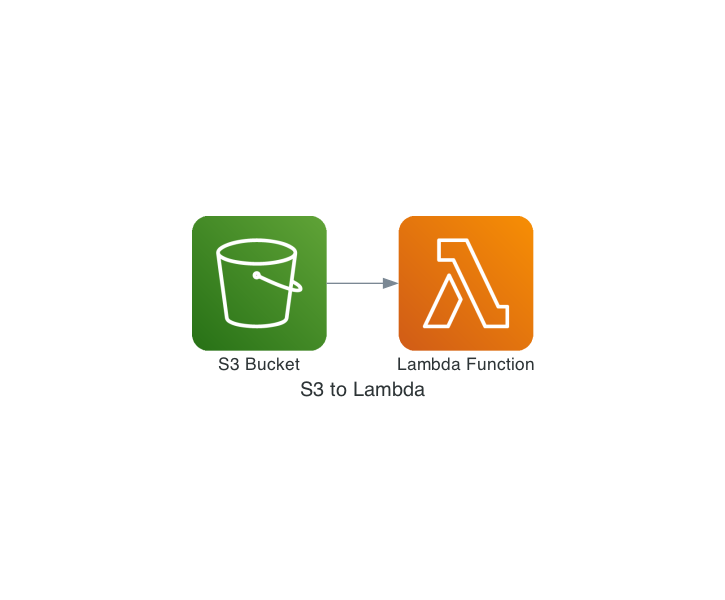

In [8]:
query = "A diagram that shows an s3 bucket connected to a lambda function"
diagram_gen_tool = DiagramCreationTool()
diagram_gen_tool(query)

### Starting the agent

To start the agent we select what LLM to use ( Starcoder https://huggingface.co/bigcode/starcoder for this example) our custom prompt, and additional tools. We also delete the default tools so the agent so just uses our custom tools.


In [9]:
# Start Agent
agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder", run_prompt_template=sa_prompt,additional_tools=[code_gen_tool,well_arch_tool,diagram_gen_tool])

default_tools = ['document_qa',
 'image_captioner',
 'image_qa',
 'image_segmenter',
 'transcriber',
 'summarizer',
 'text_classifier',
 'text_qa',
 'text_reader',
 'translator',
 'image_transformer',
 'text_downloader',
 'image_generator',
 'video_generator',
]

# Remove default tools
for tool in default_tools:
    try:
        del agent.toolbox[tool]
    except:
        continue

==Explanation from the agent==
I will use the following


==Code generated by the agent==
architecture_diagram = diagram_creation_tool(query="Draw an AWS diagram of a video processing solution")


==Result==
from diagrams import Cluster, Diagram
from diagrams.aws.compute import EC2, Lambda
from diagrams.aws.integration import SQS
from diagrams.aws.storage import S3
from diagrams.aws.database import Dynamodb
from diagrams.aws.analytics import Kinesis

with Diagram("Video Processing Solution", show=False):
    with Cluster("Video Processing"):
        processing_ec2 = EC2("Processing EC2 Instance")
        lambda_function = Lambda("Lambda Function")

    with Cluster("Queue"):
        video_queue = SQS("Video Queue")

    with Cluster("Storage"):
        raw_videos_bucket = S3("Raw Videos")
        processed_videos_bucket = S3("Processed Videos")

    with Cluster("Database"):
        video_metadata_db = Dynamodb("Video Metadata")

    with Cluster("Stream"):
        video_stream = Kines

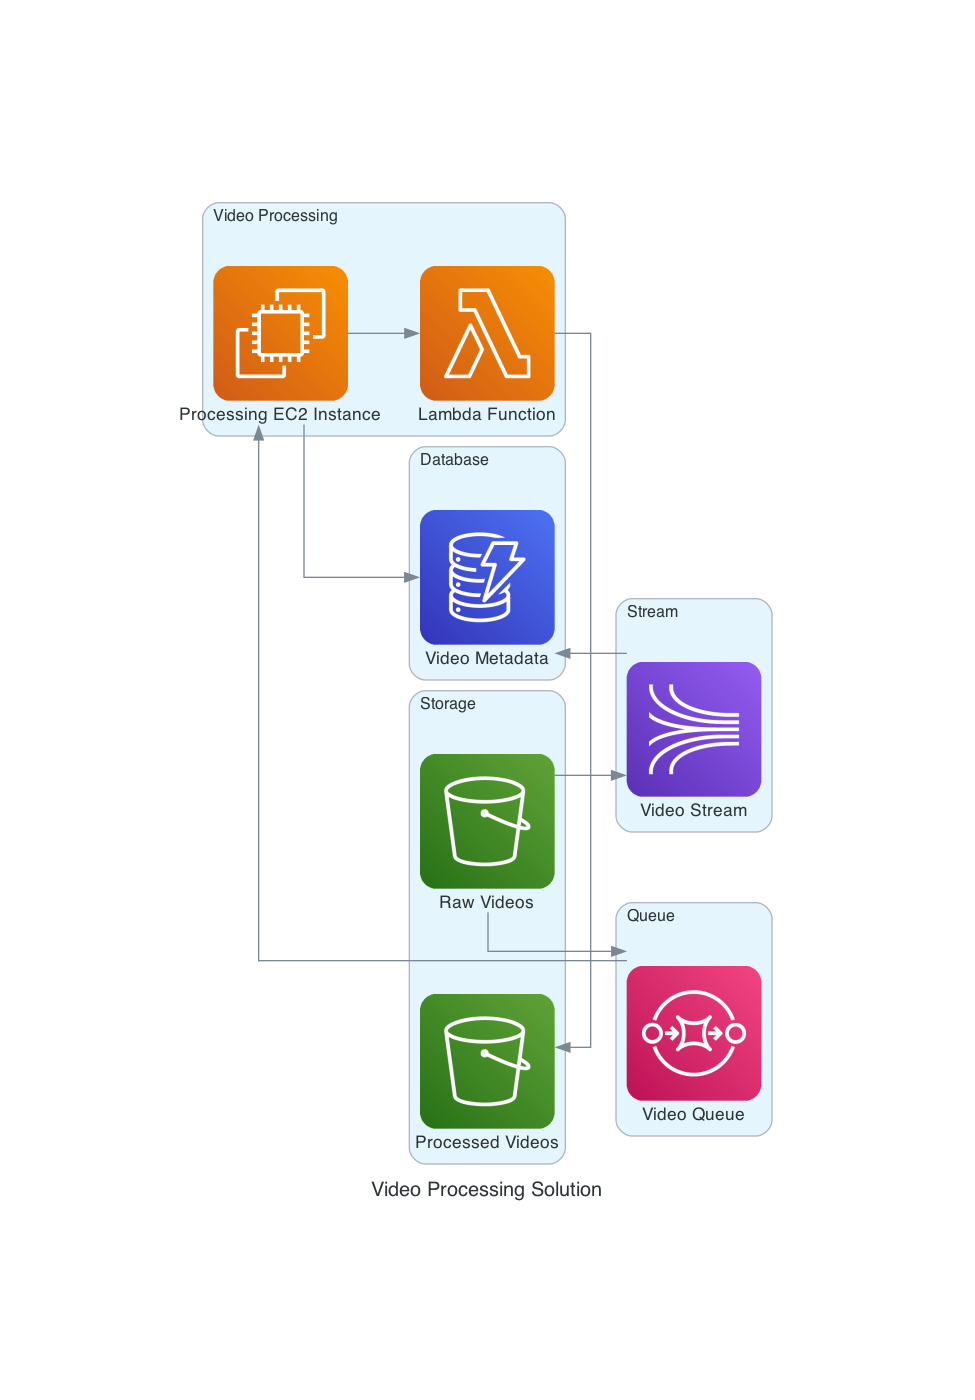

In [15]:
agent.run("Draw an AWS diagram of a video processing solution")

In [16]:
agent.run("How would I secure my Amazon S3 buckets?")

==Explanation from the agent==
I will use the following - Well-Architected Framework Query Tool to extract information from the AWS Well-Architected Framework.
- Code Generation Tool to generate Python code based on the provided requirements.


==Code generated by the agent==
response = well_architected_tool(query="How would I secure my Amazon S3 buckets?")
print(f"{response}.")

cloudformation_script = code_generation_tool(prompt="How would I secure my Amazon S3 buckets?")
print(f"{cloudformation_script}")


==Result==
{'ans': '\nUse AWS IAM Access Analyzer to check S3 bucket policies, review bucket permissions, enable versioning and object lock, implement monitoring and alerting, and use AWS Trusted Advisor to check for open access permissions.', 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_protect_data_rest_access_control.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_protect_data_rest_access_control.html\nhttps://docs.aws.a

"\nTo secure your Amazon S3 buckets, you can follow these steps:\nUse strong and unique passwords for your Amazon S3 account.\nEnable encryption for your Amazon S3 buckets.\nUse access control lists (ACLs) to control access to your Amazon S3 buckets.\nUse bucket policies to control access to your Amazon S3 buckets.\nUse bucket locks to prevent accidental deletion or modification of your Amazon S3 buckets.\nMonitor your Amazon S3 buckets for unauthorized access or suspicious activity.\nRegularly back up your Amazon S3 buckets.\nIt's also recommended to use multi-factor authentication (MFA) for added security."

In [17]:
agent.run("Generate code to upload a file to an Amazon S3 bucket")

==Explanation from the agent==
I will use the following


==Code generated by the agent==

s3_upload_code = code_generation_tool(prompt="Upload a file to an Amazon S3 bucket")
print(f"{s3_upload_code}")


==Result==

To upload a file to an Amazon S3 bucket, you can use the AWS SDK for JavaScript (v3) or the AWS CLI.
AWS SDK for JavaScript (v3):
Copy code
const
aws =
require
(
'aws-sdk'
);
const
s3 =
new
aws.S3();
const
params = {
Bucket
:
'your-bucket-name'
,
Key
:
'your-key-name'
,
Body
:
'your-file-name'
,
};
s3.upload(params,
function
(
err, data) {
if
(err) {
console
.
error
(err);
return
;
  }
console
.
log
(data);
});
AWS CLI:
Copy code
aws s3 cp your-file-name your-bucket-name/your-key-name
Replace
your-bucket-name
and
your-key-name
with the appropriate values for your bucket and key.
You can also use the AWS Management Console to upload a file to an Amazon S3 bucket. To do this, navigate to the Amazon S3 service in the AWS Management Console, select the bucket you want to uploa

'\nTo upload a file to an Amazon S3 bucket, you can use the AWS SDK for JavaScript (v3) or the AWS CLI.\nAWS SDK for JavaScript (v3):\nCopy code\nconst\naws =\nrequire\n(\n\'aws-sdk\'\n);\nconst\ns3 =\nnew\naws.S3();\nconst\nparams = {\nBucket\n:\n\'your-bucket-name\'\n,\nKey\n:\n\'your-key-name\'\n,\nBody\n:\n\'your-file-name\'\n,\n};\ns3.upload(params,\nfunction\n(\nerr, data) {\nif\n(err) {\nconsole\n.\nerror\n(err);\nreturn\n;\n  }\nconsole\n.\nlog\n(data);\n});\nAWS CLI:\nCopy code\naws s3 cp your-file-name your-bucket-name/your-key-name\nReplace\nyour-bucket-name\nand\nyour-key-name\nwith the appropriate values for your bucket and key.\nYou can also use the AWS Management Console to upload a file to an Amazon S3 bucket. To do this, navigate to the Amazon S3 service in the AWS Management Console, select the bucket you want to upload the file to, and click the "Upload" button. You can then select the file you want to upload and click "Open" to upload it.'